In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models

In [0]:
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)

    my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = data.DataLoader(my_dataset) # create your dataloader
    return my_dataloader

In [5]:
#resnet18 = models.resnet18(num_classes=10, pretrained=False)

transform = transforms.ToTensor()
batch_size=64

trainset = datasets.CIFAR10('cifar-10', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('cifar-10', download=True, train=False, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [30000, 20000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting cifar-10/cifar-10-python.tar.gz to cifar-10
Files already downloaded and verified


In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [0]:
import time
num_epochs = 50
learning_rates = [0.00001, 0.0001, 0.001, 0.1, 0.7, 10]
losses = []
for lr in learning_rates:
  print()
  print('Current learning rate is', lr)
  resnet18 = models.resnet18(num_classes=10, pretrained=False)
  resnet18 = resnet18.cuda()
  opt = torch.optim.SGD(resnet18.parameters(), lr=lr)
  train_loss = []
  val_accuracy = []
  
  for epoch in range(num_epochs):
      start_time = time.time()
      k = 0
      resnet18.train(True)
      for (X_batch, y_batch) in trainloader:
          loss = compute_loss(X_batch, y_batch)
          loss.backward()
          opt.step()
          opt.zero_grad()
          train_loss.append(loss.data.cpu().numpy())

      resnet18.train(False)
      for (X_batch, y_batch) in valloader:
          y_batch = y_batch.cuda()
          logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
          y_pred = logits.max(1)[1].data
          val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      print("  training loss (in-iteration): \t{:.6f}".format(
          np.mean(train_loss[-len(trainset) // batch_size :])))
      print("  validation accuracy: \t\t\t{:.2f} %".format(
          np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
      losses.append(np.array(train_loss).mean())


Current learning rate is 1e-05
Epoch 1 of 50 took 19.281s
  training loss (in-iteration): 	2.554401
  validation accuracy: 			10.80 %
Epoch 2 of 50 took 19.254s
  training loss (in-iteration): 	2.488634
  validation accuracy: 			11.43 %
Epoch 3 of 50 took 19.208s
  training loss (in-iteration): 	2.442014
  validation accuracy: 			11.97 %
Epoch 4 of 50 took 19.183s
  training loss (in-iteration): 	2.402627
  validation accuracy: 			12.93 %
Epoch 5 of 50 took 19.262s
  training loss (in-iteration): 	2.371946
  validation accuracy: 			13.66 %
Epoch 6 of 50 took 19.253s
  training loss (in-iteration): 	2.343227
  validation accuracy: 			14.21 %
Epoch 7 of 50 took 19.162s
  training loss (in-iteration): 	2.320277
  validation accuracy: 			15.00 %
Epoch 8 of 50 took 19.813s
  training loss (in-iteration): 	2.294996
  validation accuracy: 			15.68 %
Epoch 9 of 50 took 19.852s
  training loss (in-iteration): 	2.278253
  validation accuracy: 			16.35 %
Epoch 10 of 50 took 19.236s
  training lo

KeyboardInterrupt: ignored

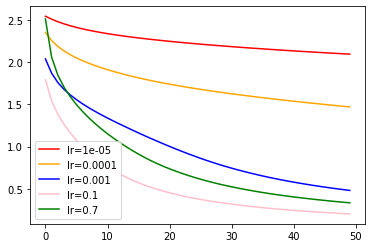

In [0]:
colors = ['red', 'orange', 'blue', 'pink', 'green', 'violet', 'coral']

for i in range(len(losses) // num_epochs - 1):
  plt.plot(list(range(num_epochs)), losses[i * num_epochs: (i + 1) * num_epochs], 
              color=colors[i], label='lr=' + str(learning_rates[i]))
#plt.xlim((1, 100))
plt.legend()
plt.show()

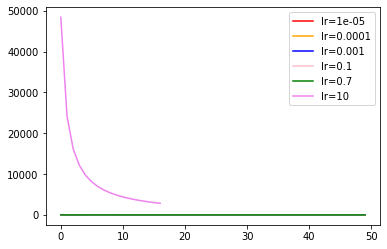

In [0]:
for i in range(len(losses) // num_epochs):
  plt.plot(list(range(num_epochs)), losses[i * num_epochs: (i + 1) * num_epochs], 
              color=colors[i], label='lr=' + str(learning_rates[i]))
#plt.xlim((1, 100))
plt.legend()
plt.show()

In [0]:
#clr
import time
resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 20
start_lr = 1e-5
end_lr = 0.1
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        if it == 0:
          lr_find_loss.append(loss)
        else:
          loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
          lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(trainset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

Epoch 1 of 20 took 20.050s
  training loss (in-iteration): 	2.072595
  validation accuracy: 			35.35 %
Epoch 2 of 20 took 20.378s
  training loss (in-iteration): 	1.607396
  validation accuracy: 			42.83 %
Epoch 3 of 20 took 20.613s
  training loss (in-iteration): 	1.360333
  validation accuracy: 			47.43 %
Epoch 4 of 20 took 20.976s
  training loss (in-iteration): 	1.162281
  validation accuracy: 			49.59 %
Epoch 5 of 20 took 20.834s
  training loss (in-iteration): 	1.022081
  validation accuracy: 			49.87 %
Epoch 6 of 20 took 20.662s
  training loss (in-iteration): 	0.961321
  validation accuracy: 			49.44 %
Epoch 7 of 20 took 20.841s
  training loss (in-iteration): 	0.977245
  validation accuracy: 			50.04 %
Epoch 8 of 20 took 20.787s
  training loss (in-iteration): 	0.968029
  validation accuracy: 			51.07 %
Epoch 9 of 20 took 20.771s
  training loss (in-iteration): 	0.965045
  validation accuracy: 			53.07 %
Epoch 10 of 20 took 20.735s
  training loss (in-iteration): 	0.956457
  v

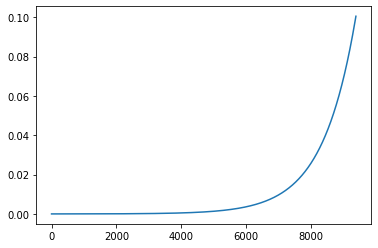

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

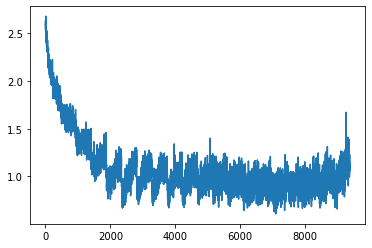

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [0]:
#clr
resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 20
start_lr = 1e-3
end_lr = 0.7
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

lr_lambda = lambda x: math.exp(x * math.log(start_lr / end_lr) / (num_epochs * len(trainset)/batch_size))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

train_loss = []
val_accuracy = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        if k % 20 == 0:
          print(k, end=' ')
        k += 1

        scheduler.step()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        if it == 0:
          lr_find_loss.append(loss)
        else:
          loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
          lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(trainset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 1 of 20 took 20.678s
  training loss (in-iteration): 	1.502681
  validation accuracy: 			49.25 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 2 of 20 took 20.399s
  training loss (in-iteration): 	1.083895
  validation accuracy: 			57.97 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 3 of 20 took 20.226s
  training loss (in-iteration): 	0.859203
  validation accuracy: 			54.16 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 4 of 20 took 20.149s
  training loss (in-iteration): 	0.664161
  validation accuracy: 			67.98 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 5 of 20 took 20.159s
  training loss (in-iteration): 	0.467716
  validation accuracy: 			70.20 %
0 20 40 60 80 100 120 140 160 180 2

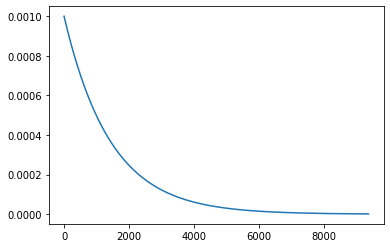

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

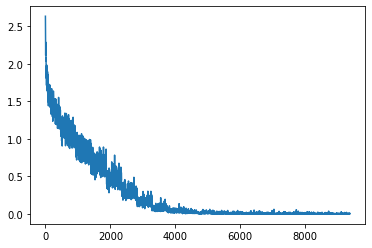

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [0]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. * math.exp(-x * 0.1)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [0]:
import time
resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 40
start_lr = 1e-5
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        opt.zero_grad()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        lr_find_loss.append(loss)
        #if it == 0:
        #  lr_find_loss.append(loss)
        #else:
        #  loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
        #  lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(trainset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

Epoch 1 of 40 took 26.661s
  training loss (in-iteration): 	2.588186
  validation accuracy: 			10.53 %
Epoch 2 of 40 took 26.503s
  training loss (in-iteration): 	2.497866
  validation accuracy: 			12.19 %
Epoch 3 of 40 took 26.326s
  training loss (in-iteration): 	2.373419
  validation accuracy: 			15.57 %
Epoch 4 of 40 took 26.307s
  training loss (in-iteration): 	2.246056
  validation accuracy: 			19.53 %
Epoch 5 of 40 took 26.339s
  training loss (in-iteration): 	2.134931
  validation accuracy: 			23.01 %
Epoch 6 of 40 took 26.322s
  training loss (in-iteration): 	2.066662
  validation accuracy: 			24.66 %
Epoch 7 of 40 took 26.387s
  training loss (in-iteration): 	2.029421
  validation accuracy: 			25.45 %
Epoch 8 of 40 took 26.299s
  training loss (in-iteration): 	2.004962
  validation accuracy: 			26.16 %
Epoch 9 of 40 took 26.318s
  training loss (in-iteration): 	1.991646
  validation accuracy: 			26.41 %
Epoch 10 of 40 took 26.463s
  training loss (in-iteration): 	1.979485
  v

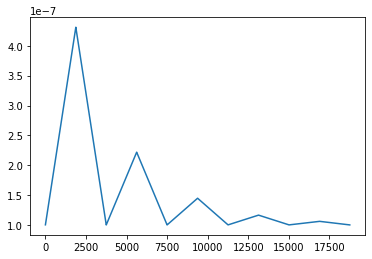

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

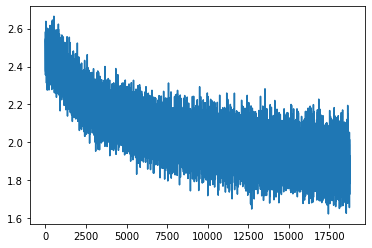

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [8]:
import time
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. #* math.exp(-x)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 40
start_lr = 1e-5
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        opt.zero_grad()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        lr_find_loss.append(loss)
        #if it == 0:
        #  lr_find_loss.append(loss)
        #else:
        #  loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
        #  lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(trainset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

Epoch 1 of 40 took 26.391s
  training loss (in-iteration): 	2.488086
  validation accuracy: 			11.52 %
Epoch 2 of 40 took 25.883s
  training loss (in-iteration): 	2.401780
  validation accuracy: 			14.33 %
Epoch 3 of 40 took 26.174s
  training loss (in-iteration): 	2.296302
  validation accuracy: 			18.11 %
Epoch 4 of 40 took 25.932s
  training loss (in-iteration): 	2.187718
  validation accuracy: 			21.56 %
Epoch 5 of 40 took 25.896s
  training loss (in-iteration): 	2.090747
  validation accuracy: 			24.30 %
Epoch 6 of 40 took 26.029s
  training loss (in-iteration): 	2.025414
  validation accuracy: 			26.21 %
Epoch 7 of 40 took 26.100s
  training loss (in-iteration): 	1.986491
  validation accuracy: 			26.93 %
Epoch 8 of 40 took 26.245s
  training loss (in-iteration): 	1.964714
  validation accuracy: 			27.58 %
Epoch 9 of 40 took 26.546s
  training loss (in-iteration): 	1.951843
  validation accuracy: 			28.18 %
Epoch 10 of 40 took 26.797s
  training loss (in-iteration): 	1.933103
  v

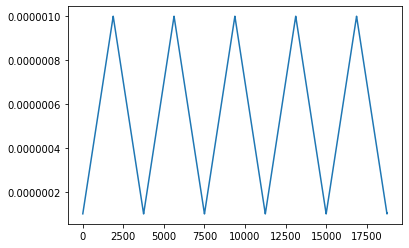

In [9]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

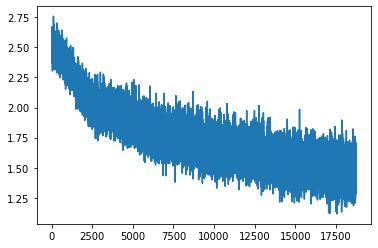

In [10]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [11]:
import time
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. * (10 - 0.1 * x)#* math.exp(-x)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 40
start_lr = 1e-5
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        opt.zero_grad()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        lr_find_loss.append(loss)
        #if it == 0:
        #  lr_find_loss.append(loss)
        #else:
        #  loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
        #  lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(trainset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

Epoch 1 of 40 took 26.017s
  training loss (in-iteration): 	2.542801
  validation accuracy: 			15.57 %
Epoch 2 of 40 took 26.135s
  training loss (in-iteration): 	2.174142
  validation accuracy: 			27.04 %
Epoch 3 of 40 took 25.979s
  training loss (in-iteration): 	1.893183
  validation accuracy: 			34.41 %
Epoch 4 of 40 took 26.330s
  training loss (in-iteration): 	1.698184
  validation accuracy: 			38.82 %
Epoch 5 of 40 took 25.988s
  training loss (in-iteration): 	1.538971
  validation accuracy: 			41.98 %
Epoch 6 of 40 took 26.087s
  training loss (in-iteration): 	1.420187
  validation accuracy: 			43.29 %
Epoch 7 of 40 took 26.143s
  training loss (in-iteration): 	1.345910
  validation accuracy: 			43.98 %
Epoch 8 of 40 took 26.042s
  training loss (in-iteration): 	1.304250
  validation accuracy: 			44.11 %
Epoch 9 of 40 took 26.153s
  training loss (in-iteration): 	1.286450
  validation accuracy: 			44.35 %
Epoch 10 of 40 took 26.010s
  training loss (in-iteration): 	1.271685
  v

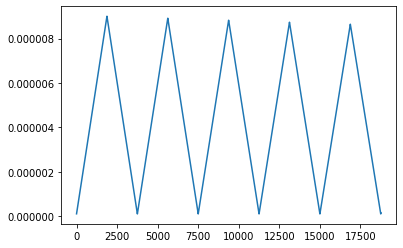

In [12]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

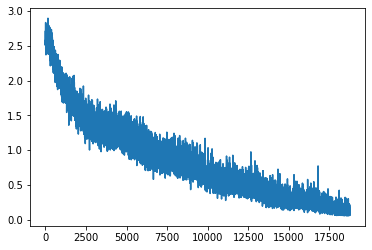

In [13]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [14]:
import time
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. * (10 - 0.7 * x)#* math.exp(-x)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 40
start_lr = 1e-5
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        opt.zero_grad()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        lr_find_loss.append(loss)
        #if it == 0:
        #  lr_find_loss.append(loss)
        #else:
        #  loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
        #  lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(trainset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

Epoch 1 of 40 took 25.985s
  training loss (in-iteration): 	2.404135
  validation accuracy: 			16.43 %
Epoch 2 of 40 took 26.243s
  training loss (in-iteration): 	2.107014
  validation accuracy: 			28.25 %
Epoch 3 of 40 took 25.946s
  training loss (in-iteration): 	1.858173
  validation accuracy: 			34.57 %
Epoch 4 of 40 took 25.831s
  training loss (in-iteration): 	1.674405
  validation accuracy: 			38.91 %
Epoch 5 of 40 took 26.030s
  training loss (in-iteration): 	1.525421
  validation accuracy: 			41.61 %
Epoch 6 of 40 took 26.075s
  training loss (in-iteration): 	1.420963
  validation accuracy: 			43.22 %
Epoch 7 of 40 took 25.914s
  training loss (in-iteration): 	1.349437
  validation accuracy: 			43.76 %
Epoch 8 of 40 took 26.014s
  training loss (in-iteration): 	1.308309
  validation accuracy: 			43.97 %
Epoch 9 of 40 took 26.008s
  training loss (in-iteration): 	1.292856
  validation accuracy: 			44.18 %
Epoch 10 of 40 took 25.942s
  training loss (in-iteration): 	1.279640
  v

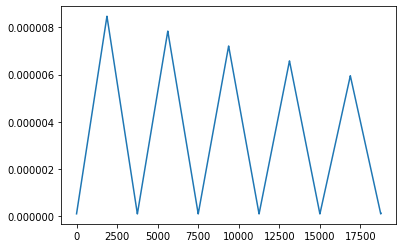

In [15]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

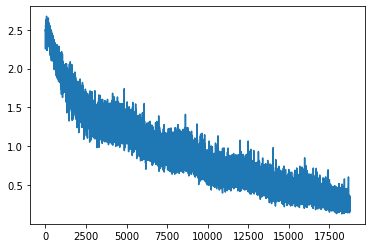

In [16]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()